In [1]:
# most of the code cribbed from
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
#
# but I had to modify in a few ways to get it working, plus figure out how to get it to 
# train anything.  Will hopefully fix this up to be more readable & useful for educational 
# purposes.  Ugh, original routine multiplying random numbers by 0.1 really was NOT helpful.
#
# Roger Allen - 2/1/2020
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def init_layers(nn, seed):
    """modify nn['params'] in place"""
    nn_params = nn["params"] = {}
    nn_architecture = nn["architecture"]

    np.random.seed(seed)

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # BUGFIX! original code multiplied all randn values
        # by 0.1 which REALLY screws things up and makes
        # the nets VERY HARD TO TRAIN.
        nn_params['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size)
        nn_params['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, nn):
    nn_params = nn["params"]
    nn_architecture = nn["architecture"]
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = nn_params["W" + str(layer_idx)]
        b_curr = nn_params["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return float(np.squeeze(cost))

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

# from gist comment
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, nn):
    nn_params = nn["params"]
    nn_architecture = nn["architecture"]
    grads_values = {}
    #m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = nn_params["W" + str(layer_idx_curr)]
        b_curr = nn_params["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

def update(nn, grads_values, learning_rate):
    """update nn['params'] in place"""
    nn_params = nn["params"]
    for idx in range(len(nn["architecture"])):
        layer_idx = idx + 1 # changed to add this
        nn_params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        nn_params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
def train(X, Y, nn, epochs, learning_rate, seed=2):
    #breakpoint()
    if nn["params"] == None:
        init_layers(nn, seed)
    cost_history = []
    accuracy_history = []
    
    for _ in range(epochs):
        Y_hat, cache = full_forward_propagation(X, nn)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cache, nn)
        update(nn, grads_values, learning_rate)
        
    return cost_history, accuracy_history

def predict(X, nn):
    Y_hat, _ = full_forward_propagation(X, nn)
    Y_hat_ = convert_prob_into_class(Y_hat)
    return Y_hat_, Y_hat

def train_and_check(X,Y,nn,epochs,learning_rate,seed):
    fig = plt.figure(figsize=(9,3))
    cost_history, accuracy_history = train(X, Y, nn, epochs, learning_rate, seed)
    plt.plot(cost_history,label="cost")
    plt.plot(accuracy_history,label="accuracy")
    plt.legend()
    plt.title("Training History")
    print(f"Test Predict:\nX = {X}\nY_predict = {predict(X, nn)}")

Test Predict:
X = [[0. 1.]]
Y_predict = (array([[0., 1.]]), array([[0.00115121, 0.99027491]]))


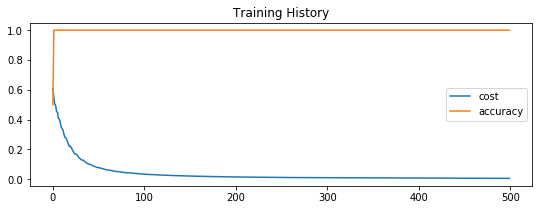

In [3]:
# simple input-follows-output works fine
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 1, "output_dim": 1, "activation": "relu"},
        {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0],[1.0]]).T
Y = np.array([[0.0],[1.0]]).T
epochs = 500
seed = 1999 #42

learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 1.]]), array([[0.02131924, 0.99860627, 0.9986432 , 0.99999996]]))


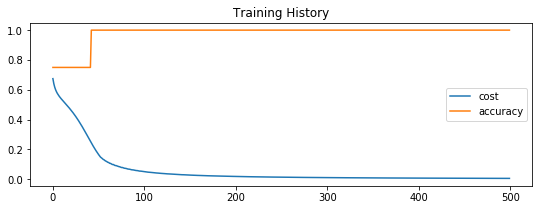

In [4]:
# OR gate works fine
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "relu"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[1.0]]).T
seed = 1984

epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 1.]]), array([[0.04103861, 0.98093511, 0.98086523, 0.99615731]]))


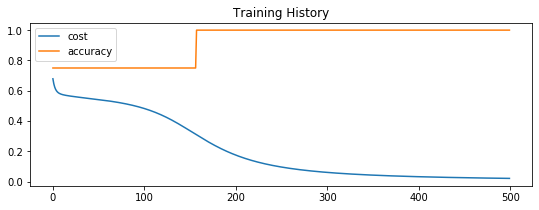

In [5]:
# full sigmoid OR gate works fine
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
seed = 1984
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 0., 0., 1.]]), array([[0.0014526 , 0.03835288, 0.04069027, 0.88026847]]))


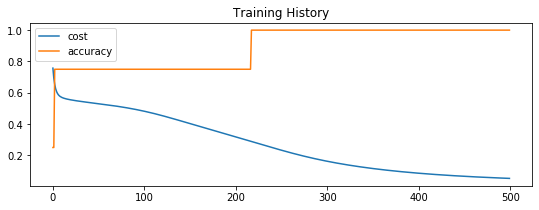

In [6]:
# full sigmoid AND gate works fine
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[0.0],[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
seed = 1984
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 0.]]), array([[0.03582764, 0.96325153, 0.96325133, 0.0509028 ]]))


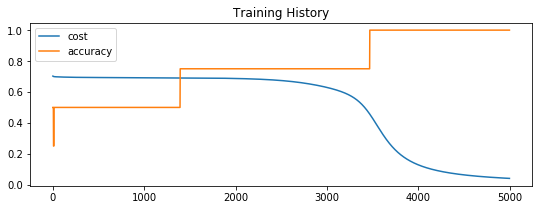

In [7]:
# full sigmoid XOR gate
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[0.0]]).T
epochs = 5000
learning_rate = 0.2
seed = 1984
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 1.]]
Y_predict = (array([[0., 1.]]), array([[0.04380136, 0.96881675]]))


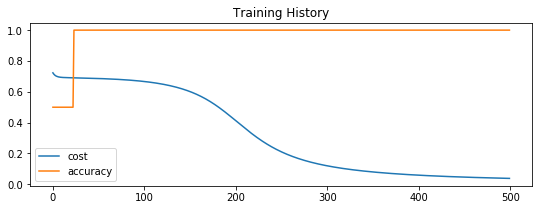

In [8]:
# try a hidden layer follow -- works with different learning rate
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
        {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
        {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0],[1.0]]).T
Y = np.array([[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
seed = 1984
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 0., 0., 1.]]), array([[5.96451760e-04, 2.24621605e-03, 1.66787286e-03, 9.94684493e-01]]))


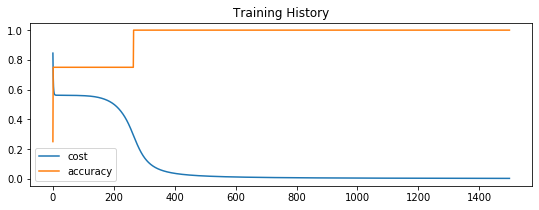

In [9]:
# AND with a hidden layer seems to work fine...
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[0.0],[0.0],[1.0]]).T
epochs = 1500
seed = 1928

learning_rate = 1.0
train_and_check(X,Y,nn,epochs,learning_rate,seed)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 0.]]), array([[0.03720046, 0.96402976, 0.9639739 , 0.01514994]]))


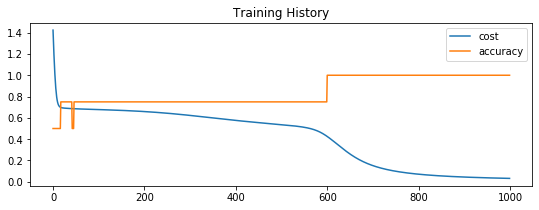

In [10]:
# XOR with a hidden layer
nn = {
    "params": None,
    "architecture": [
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
        {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    ]
}
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[0.0]]).T

seed = 1010
epochs = 1000
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate,seed)


In [11]:
nn

{'params': {'W1': array([[-4.02884515, -4.01011526],
         [-4.2573919 , -4.23538468]]), 'b1': array([[1.54329795],
         [6.55898209]]), 'W2': array([[ 6.46014268, -4.95376146],
         [-0.18138454, -4.43843842]]), 'b2': array([[1.72702401],
         [1.19489801]]), 'W3': array([[-8.28335141, -3.33753731]]), 'b3': array([[4.23778877]])},
 'architecture': [{'input_dim': 2, 'output_dim': 2, 'activation': 'sigmoid'},
  {'input_dim': 2, 'output_dim': 2, 'activation': 'sigmoid'},
  {'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'}]}